In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from model import *

num_samples = 10
unlabel_prob = 0.95 # probability of labels to be unlabeled
percentile = 0     # when a graph is not given, construct a graph 
                    # dropping nodes under this percentile 

sigma = 1         # sigma hyperparameter for RBF kernel

hard = False


%matplotlib inline

In [2]:
true_labels, features, labels, is_labeled, labeled_indices, unlabeled_indices = DataT.DataT.load_mnist(rel_path='../')
graph = []

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
np.random.seed(1)
sigma = np.random.uniform(0.2,5)
theta = np.random.uniform(0.2,5,(1,features.shape[1]))

solution  = true_labels[unlabeled_indices]

In [4]:
print('weights')
num_nodes = len(labels)
num_classes = true_labels.shape[1]

# crossval
np.random.seed(None)
num_labeled = len(labeled_indices)
num_unlabeled = len(unlabeled_indices)
# p=float(args.crossval_p)
# val_num_labeled = int(num_labeled*p)
# val_num_unlabeled = int(num_unlabeled*p)
val_num_labeled = 600
val_num_unlabeled = 10000
df = pd.DataFrame(columns=['accuracy','mse','log'])

weights


In [5]:
val_labeled_indices_original = sorted(np.random.choice(labeled_indices, val_num_labeled))
val_unlabeled_indices_original = sorted(np.random.choice(unlabeled_indices, val_num_unlabeled))
val_indices_original = sorted(np.append(val_labeled_indices_original,val_unlabeled_indices_original))
val_labeled_indices = np.where(np.isin(val_indices_original,val_labeled_indices_original))[0]
val_unlabeled_indices = np.where(np.isin(val_indices_original,val_unlabeled_indices_original))[0]
val_labels = labels[val_indices_original]
val_is_labeled = is_labeled[val_indices_original]
val_solution = true_labels[val_unlabeled_indices_original]
val_features = features[val_indices_original]
val_weights, val_graph = utils.rbf_kernel(val_features,
                                      s=sigma,
                                      G=[],
                                      percentile=0)
# val_graph = graph[np.ix_(val_indices_original,val_indices_original)]
val_true_labels = true_labels[val_indices_original]
val_num_nodes = len(val_indices_original)

graph constructed


In [22]:
lp = LPT.LPT()
lp_iter_prediction = lp.iter(val_labels,
                             val_weights,
                             val_is_labeled,
                             num_iter=100,multiclass=True)
lp_iter_onehot = utils.prob_to_one_hot(lp_iter_prediction)

accuracy = utils.accuracy(val_solution, lp_iter_onehot[val_unlabeled_indices],multiclass=True)
mse = utils.mse(val_solution, lp_iter_prediction[val_unlabeled_indices],num_classes)
log = utils.log_loss(val_solution, lp_iter_prediction[val_unlabeled_indices],multiclass=True)


In [25]:
val_solution.shape,lp_iter_onehot[val_unlabeled_indices].shape

((10000, 10), (10000, 10))

In [245]:
from sklearn.metrics.pairwise import rbf_kernel
K = rbf_kernel(val_features, gamma=1/sigma**2)

In [227]:
np.fill_diagonal(K, 0)
k=50
sortK = K.argsort()
knn = sortK[:,-k:]
G1 = np.zeros(K.shape)
G1[np.arange(K.shape[0]).reshape(-1,1),knn] = 1
G2 = G1.T
G = np.logical_or(G1,G2)
K[~G] = 0 

In [247]:
K[-1]

array([  4.53256183e-12,   5.13449110e-11,   2.88776944e-14, ...,
         2.24949291e-12,   1.00000000e+00,   1.00000000e+00], dtype=float32)

In [232]:
G.shape

(10600, 10600)

In [233]:
G1[np.arange(K.shape[0]).reshape(-1,1),knn].shape

(10600, 50)

In [234]:
G1

array([[ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  1.]])

In [16]:
data, validation_data = DataT.DataT.prepare(labels,labeled_indices,true_labels,2,num_classes,num_samples,num_nodes)

12.0

In [3]:
lp = LPT.LPT()
lp_closed_prediction = lp.closed(labels,
                                 weights,
                                 labeled_indices,
                                 unlabeled_indices)
lp_closed_onehot = utils.prob_to_one_hot(lp_closed_prediction)
lp_iter_prediction = lp.iter(labels,
                             weights,
                             is_labeled,
                             num_iter=100,multiclass=True)
lp_iter_onehot = utils.prob_to_one_hot(lp_iter_prediction)

In [4]:
print("[Closed]　Accuracy:", utils.accuracy(solution, lp_closed_onehot,multiclass=True), 
      "MSE:", utils.mse(solution, lp_closed_prediction, num_classes),
      "Log:", utils.log_loss(solution, lp_closed_prediction,multiclass=True))
print("[Iter]　Accuracy:", utils.accuracy(solution, lp_iter_onehot[unlabeled_indices],multiclass=True), 
      "MSE:", utils.mse(solution, lp_iter_prediction[unlabeled_indices],num_classes),
      "Log:", utils.log_loss(solution, lp_iter_prediction[unlabeled_indices],multiclass=True))

[Closed]　Accuracy: 0.704661016949 MSE: 0.409111919586 Log: 0.597614373884
[Iter]　Accuracy: 0.704661016949 MSE: 0.408865031679 Log: 0.597338913222


In [5]:
data, validation_data = DataT.DataT.prepare(labels,labeled_indices,true_labels,2,num_classes,num_samples,num_nodes)

In [6]:
dlp = DeepLPT.DeepLPT(num_nodes,num_classes,weights,num_iter=100,lr=0.1)


In [7]:
dlp_rbf = DeepLP_RBFT.DeepLP_RBFT(num_nodes,num_classes,features, graph, sigma, num_iter=100, lr=0.01, loss_type='log',graph_sparse=True) # usually 1

In [8]:
dlp_rbf_prediction,_ = dlp_rbf.labelprop(validation_data)

{'true_loss': 0.59735167, 'true_accuracy': 0.70466101}


In [9]:
dlp_rbf.train(data,validation_data,200)

epoch: -1 labeled loss: 0.494708 unlabeled loss: 0.597379 accuracy: 0.704742 true unlabeled loss: 0.597352 true accuracy: 0.704661
sigma: 1.0
--- 4.521946907043457 seconds ---
epoch: 0 labeled loss: 0.4944 unlabeled loss: 0.596834 accuracy: 0.704742 true unlabeled loss: 0.596784 true accuracy: 0.704661
sigma: 0.99
--- 4.273789167404175 seconds ---
epoch: 1 labeled loss: 0.493994 unlabeled loss: 0.596182 accuracy: 0.704742 true unlabeled loss: 0.596111 true accuracy: 0.704661
sigma: 0.979991
--- 4.472275972366333 seconds ---
epoch: 2 labeled loss: 0.493643 unlabeled loss: 0.595582 accuracy: 0.704742 true unlabeled loss: 0.595484 true accuracy: 0.704661
sigma: 0.969965
--- 4.390889883041382 seconds ---
epoch: 3 labeled loss: 0.49331 unlabeled loss: 0.59499 accuracy: 0.704742 true unlabeled loss: 0.594867 true accuracy: 0.704661
sigma: 0.959916
--- 3.9609789848327637 seconds ---
epoch: 4 labeled loss: 0.492866 unlabeled loss: 0.594286 accuracy: 0.704742 true unlabeled loss: 0.594131 true 

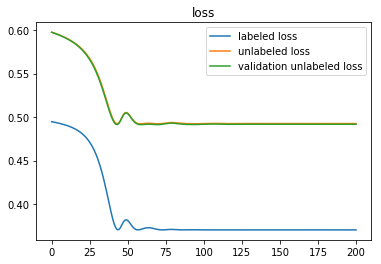

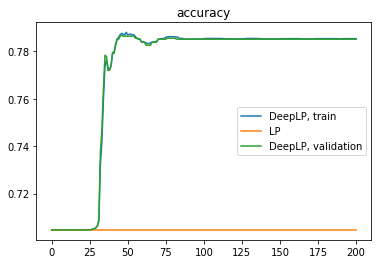

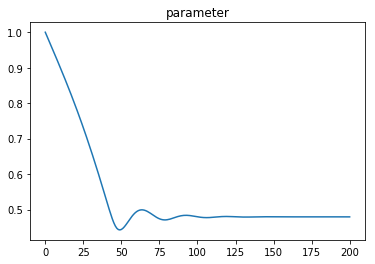

In [10]:
dlp_rbf.plot()